In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from scipy.ndimage import binary_dilation
import matplotlib.patches as patches
from IPython.display import HTML


In [ ]:
def build_up_b_2(rho, dt, u, v, dx, dy):
    """
    Construye el término del lado derecho de la ecuación de Poisson para la presión a partir de los campos de velocidad u y v.
    Parameters:
     - rho : Densidad del fluido.
     - dt : Paso temporal.
     - u : Componente horizontal de la velocidad.
     - v : Componente vertical de la velocidad.
     - dx : Tamaño de celda en x (puede ser escalar o matriz).
     - dy : Tamaño de celda en y (puede ser escalar o matriz).
    Returns:
     - b : Matriz del término fuente para la ecuación de Poisson.
    """
    b = np.zeros_like(u)
    
    dx_inner = dx[1:-1, 1:-1]
    dy_inner = dy[1:-1, 1:-1]
    
    b[1:-1, 1:-1] = rho * ((1/dt) * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx_inner) +
                                     (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2*dy_inner)) -
                          ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx_inner))**2 -
                          2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2*dy_inner) *
                               (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2*dx_inner)) -
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2*dy_inner))**2)
    return b

def pressure_poisson_2(p, b, dx, dy, nit=50):
    """
    Resuelve la ecuación de Poisson para la presión usando el método iterativo de Jacobi.
    
    Parameters:
    - p : Campo de presión inicial.
    - b : Término fuente de la ecuación de Poisson.
    - dx : Tamaño de celda en x (puede ser escalar o matriz).
    - dy : Tamaño de celda en y (puede ser escalar o matriz).
    - nit : Número de iteraciones.
    
    Returns:
    - p : Campo de presión actualizado.
    """
    pn = np.empty_like(p)
    
    dx_inner = dx[1:-1, 1:-1]
    dy_inner = dy[1:-1, 1:-1]
    
    for _ in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (
            (dy_inner**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) +
             dx_inner**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1]) -
             b[1:-1, 1:-1] * dx_inner**2 * dy_inner**2)
            / (2 * (dx_inner**2 + dy_inner**2))
        )
        
        # Condiciones de frontera para la presión
        p[:, -1] = p[:, -2]  # salida
        p[:, 0] = p[:, 1]    # entrada
        p[0, :] = p[1, :]    # pared inferior
        p[-1, :] = p[-2, :]  # pared superior
        
    return p

def simulation_frontier_2(a, b, d, u0, nu, nx=41, ny=41, nt=100):
    """
    Ejecuta una simulación bidimensional del flujo de un fluido incompresible alrededor de un obstáculo circular en un canal rectangular

    Parameters:
    a : Altura del canal.
    b : Ancho del canal.
    d : Distancia del centro del obstáculo desde el borde izquierdo.
    u0 : Velocidad de entrada y de las paredes móviles.
    nu : Viscosidad cinemática del fluido.
    nx : Número de puntos en la dirección x (default = 41).
    ny : Número de puntos en la dirección y (default = 41).
    nt : Número de iteraciones.

    Returns:
    u : Componente horizontal del campo de velocidad.
    v : Componente vertical del campo de velocidad.
    p : Campo de presión.
    X : Malla de coordenadas X para visualización.
    Y : Malla de coordenadas Y para visualización.
    stepcount : Número de iteraciones realizadas hasta la convergencia.
    """
    rho = 1   # densidad
    F = 1     # fuerza externa (agregar si es necesario)
    dt = 0.001
    x = np.linspace(0, b, nx)
    y = np.linspace(0, a, ny)

    X, Y = np.meshgrid(x, y)

    # Dimensiones del obstáculo
    r = a / 25
    xc = d
    yc = a / 2

    # Máscara para el obstáculo y el contorno
    obstacle_mask = (X - xc)**2 + (Y - yc)**2 <= r**2
    obstacle_edge = binary_dilation(obstacle_mask) & (~obstacle_mask)


    # Inicialización de vectores
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    
    udiff = 0
    stepcount = 0
    forces = []
    states = []

    # Inicializacion de las nuevas matrices
    dx_base = b / (nx - 1)
    dy_base = a / (ny - 1)
    
    # Máscara de refinamiento
    refinement_radius = r * 2  # Tres veces el radio del obstáculo
    refinement_mask = (X - xc)**2 + (Y - yc)**2 <= (r + refinement_radius)**2
    
    dx_refined = np.full((ny, nx), dx_base)
    dy_refined = np.full((ny, nx), dy_base)

    # matrices finales
    dx_refined = np.where(refinement_mask, dx_base / 2, dx_base)
    dy_refined = np.where(refinement_mask, dy_base / 2, dy_base)
    
    for _ in range(nt):
        un = u.copy()
        vn = v.copy()


        # Cálculo del término b para la ecuación de Poisson (con tamaños de celda refinados)
        b = build_up_b_2(rho, dt, u, v, dx_refined, dy_refined)

        # Resolver la ecuación de Poisson
        p = pressure_poisson_2(p, b, dx_refined, dy_refined)

        # Calcular la fuerza sobre el obstáculo
        if np.any(obstacle_edge):
            force_t = np.sum(p[obstacle_edge] * dx_refined[obstacle_edge] * dy_refined[obstacle_edge])
            forces.append(force_t)
        else:
            forces.append(0)

        # Actualizar las velocidades con la fórmula de Navier-Stokes (ajustado para malla refinada)
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                         un[1:-1, 1:-1] * dt / dx_refined[1:-1, 1:-1] *
                         (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy_refined[1:-1, 1:-1] *
                         (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx_refined[1:-1, 1:-1]) *
                         (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx_refined[1:-1, 1:-1]**2 *
                         (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy_refined[1:-1, 1:-1]**2 *
                         (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) +
                         F * dt)

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                         un[1:-1, 1:-1] * dt / dx_refined[1:-1, 1:-1] * 
                         (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy_refined[1:-1, 1:-1] * 
                         (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                         dt / (2 * rho * dy_refined[1:-1, 1:-1]) * 
                         (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                         nu * (dt / dx_refined[1:-1, 1:-1]**2 * 
                         (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                               dt / dy_refined[1:-1, 1:-1]**2 * 
                         (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        # Incorporación del Obstáculo
        u[obstacle_mask] = 0
        v[obstacle_mask] = 0

        # Condiciones de frontera
        u[:, 0] = u0       # entrada
        u[:, -1] = u[:, -2] # salida
        v[:, 0] = 0
        v[:, -1] = 0

        u[0, :] = u0       # pared inferior
        u[-1, :] = u0      # pared superior
        v[0, :] = 0
        v[-1, :] = 0

        udiff = np.linalg.norm(u - un) / (np.linalg.norm(u) + 1e-6)
        if np.isnan(udiff) or udiff > 1:
            return None  # Simulación fallida
        stepcount += 1

    return True    

def simulation_2(a, b, d, u0, nu, nx=41, ny=41, nt=100):
    """
    Ejecuta una simulación bidimensional del flujo de un fluido incompresible alrededor de un obstáculo circular en un canal rectangular

    Parameters:
    a : Altura del canal.
    b : Ancho del canal.
    d : Distancia del centro del obstáculo desde el borde izquierdo.
    u0 : Velocidad de entrada y de las paredes móviles.
    nu : Viscosidad cinemática del fluido.
    nx : Número de puntos en la dirección x (default = 41).
    ny : Número de puntos en la dirección y (default = 41).
    nt : Número de iteraciones.

    Returns:
    u : Componente horizontal del campo de velocidad.
    v : Componente vertical del campo de velocidad.
    p : Campo de presión.
    X : Malla de coordenadas X para visualización.
    Y : Malla de coordenadas Y para visualización.
    stepcount : Número de iteraciones realizadas hasta la convergencia.
    """
    rho = 1   # densidad
    F = 0    # fuerza externa (agregar si es necesario)
    dt = 0.01
    x = np.linspace(0, b, nx)
    y = np.linspace(0, a, ny)

    X, Y = np.meshgrid(x, y)

    # Dimensiones del obstáculo
    r = a / 25
    xc = d
    yc = a / 2

    # Máscara para el obstáculo y el contorno
    obstacle_mask = (X - xc)**2 + (Y - yc)**2 <= r**2
    obstacle_edge = binary_dilation(obstacle_mask) & (~obstacle_mask)


    # Inicialización de vectores
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    
    udiff = 0
    stepcount = 0
    forces = []
    states = []

    # Inicializacion de las nuevas matrices
    dx_base = b / (nx - 1)
    dy_base = a / (ny - 1)
    
    # Máscara de refinamiento
    refinement_radius = r * 2  # Tres veces el radio del obstáculo
    refinement_mask = (X - xc)**2 + (Y - yc)**2 <= (r + refinement_radius)**2
    
    dx_refined = np.full((ny, nx), dx_base)
    dy_refined = np.full((ny, nx), dy_base)

    # matrices finales
    dx_refined = np.where(refinement_mask, dx_base / 2, dx_base)
    dy_refined = np.where(refinement_mask, dy_base / 2, dy_base)
    
    while udiff < nt:
        un = u.copy()
        vn = v.copy()


        # Cálculo del término b para la ecuación de Poisson (con tamaños de celda refinados)
        b = build_up_b_2(rho, dt, u, v, dx_refined, dy_refined)

        # Resolver la ecuación de Poisson
        p = pressure_poisson_2(p, b, dx_refined, dy_refined)

        # Calcular la fuerza sobre el obstáculo
        if np.any(obstacle_edge):
            force_t = np.sum(p[obstacle_edge] * dx_refined[obstacle_edge] * dy_refined[obstacle_edge])
            forces.append(force_t)
        else:
            forces.append(0)

        # Actualizar las velocidades con la fórmula de Navier-Stokes (ajustado para malla refinada)
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                         un[1:-1, 1:-1] * dt / dx_refined[1:-1, 1:-1] *
                         (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy_refined[1:-1, 1:-1] *
                         (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx_refined[1:-1, 1:-1]) *
                         (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx_refined[1:-1, 1:-1]**2 *
                         (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy_refined[1:-1, 1:-1]**2 *
                         (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) +
                         F * dt)

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                         un[1:-1, 1:-1] * dt / dx_refined[1:-1, 1:-1] * 
                         (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy_refined[1:-1, 1:-1] * 
                         (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                         dt / (2 * rho * dy_refined[1:-1, 1:-1]) * 
                         (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                         nu * (dt / dx_refined[1:-1, 1:-1]**2 * 
                         (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                               dt / dy_refined[1:-1, 1:-1]**2 * 
                         (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        # Incorporación del Obstáculo
        u[obstacle_mask] = 0
        v[obstacle_mask] = 0

        # Condiciones de frontera
        u[:, 0] = u0       # entrada
        u[:, -1] = u[:, -2] # salida
        v[:, 0] = 0
        v[:, -1] = 0

        u[0, :] = u0       # pared inferior
        u[-1, :] = u0      # pared superior
        v[0, :] = 0
        v[-1, :] = 0


        udiff = udiff + 1
        stepcount += 1
        states.append((u.copy(), v.copy(), p.copy()))  # Necesario para la animación

    return u, v, p, X, Y, stepcount, forces, states, obstacle_mask, xc, yc, r
    

In [18]:
def animate(i):
    ax.cla()
    u, v, _ = states[i]

    # Dibujar campo vectorial con quiver
    ax.quiver(X, Y, u, v, scale=50, width=0.002, headwidth=3)

    # Dibujar obstáculo
    circle = patches.Circle((xc, yc), r, color='k', fill=False, linewidth=1.5)
    ax.add_patch(circle)

    # Ajustes visuales
    ax.set_title(f"Animación fluido - Paso {i}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim(0, X.max())
    ax.set_ylim(0, Y.max())
    ax.set_aspect('equal')
    return []

def plot(X, Y, p, u, v):
    fig = plt.figure(figsize=(11, 7), dpi=100)
    plt.contourf(X, Y, p, alpha=0.5)
    plt.colorbar()
    plt.contour(X, Y, p)
    plt.streamplot(X, Y, u, v)
    plt.xlabel('X')
    plt.ylabel('Y')

def plot_forces(forces):
    plt.plot(forces)
    plt.xlabel("Paso de tiempo")
    plt.ylabel("Fuerza sobre el obstáculo")
    plt.title("Fuerza ejercida por el fluido sobre el obstáculo en el tiempo")
    plt.grid(True)
    plt.show()

C:\Users\vicen\AppData\Local\Temp\ipykernel_19616\1937970382.py:187: RuntimeWarning: invalid value encountered in scalar divide
  udiff = np.linalg.norm(u - un) / (np.linalg.norm(u) + 1e-6)


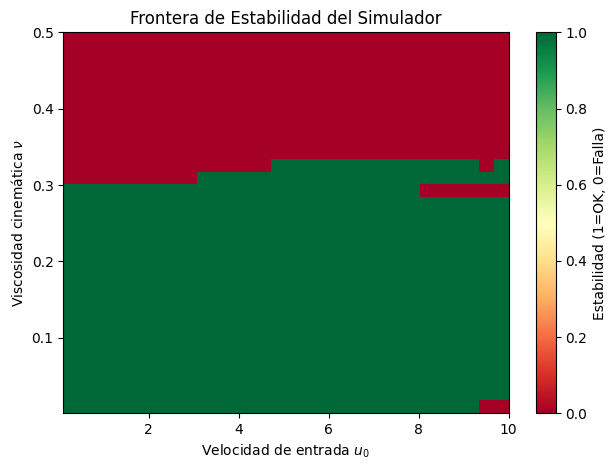

CPU times: total: 3min 3s
Wall time: 3min 15s


In [30]:
%%time
# Grid de valores para u0 y nu
u0_values = np.linspace(0.1, 10, 30)
nu_values = np.linspace(0.001, 0.5, 30)
stability_map = np.zeros((len(u0_values), len(nu_values)))

# Ejecutar simulaciones
for i, u0 in enumerate(u0_values):
    for j, nu in enumerate(nu_values):
        result = simulation_frontier_2(a=2, b=5, d=1, u0=u0, nu=nu, nt=100)
        stability_map[i, j] = 1 if result is not None else 0

# Graficar el mapa de estabilidad
plt.imshow(stability_map.T, extent=[u0_values[0], u0_values[-1], nu_values[0], nu_values[-1]],
           origin='lower', aspect='auto', cmap='RdYlGn')
plt.xlabel('Velocidad de entrada $u_0$')
plt.ylabel('Viscosidad cinemática $\\nu$')
plt.title('Frontera de Estabilidad del Simulador')
plt.colorbar(label='Estabilidad (1=OK, 0=Falla)')
plt.grid(False)
plt.tight_layout()
plt.show()

In [33]:
a = 2
b = 5
d = 2
u0 = 8
nu = .2
nt = 50

u, v, p, X, Y, sc, forces, states, om, xc, yc, r = simulation_2(a,b, d, u0, nu, nt=nt)

C:\Users\vicen\AppData\Local\Temp\ipykernel_19616\1937970382.py:21: RuntimeWarning: overflow encountered in square
  ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx_inner))**2 -
C:\Users\vicen\AppData\Local\Temp\ipykernel_19616\1937970382.py:22: RuntimeWarning: overflow encountered in multiply
  2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2*dy_inner) *
C:\Users\vicen\AppData\Local\Temp\ipykernel_19616\1937970382.py:19: RuntimeWarning: invalid value encountered in subtract
  b[1:-1, 1:-1] = rho * ((1/dt) * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx_inner) +
C:\Users\vicen\AppData\Local\Temp\ipykernel_19616\1937970382.py:24: RuntimeWarning: overflow encountered in square
  ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2*dy_inner))**2)
C:\Users\vicen\AppData\Local\Temp\ipykernel_19616\1937970382.py:279: RuntimeWarning: overflow encountered in multiply
  un[1:-1, 1:-1] * dt / dx_refined[1:-1, 1:-1] *
C:\Users\vicen\AppData\Local\Temp\ipykernel_19616\1937970382.py:281: RuntimeWarning: overflow encountered in multiply
  v

In [34]:
%%time
fig, ax = plt.subplots(figsize=(11, 7))
plt.close(fig)
ani = animation.FuncAnimation(fig, animate, frames=len(states), interval=80)
display(HTML(ani.to_jshtml()))

CPU times: total: 8.95 s
Wall time: 9.37 s
